## Analyse Préliminaire IRM_Marche
--
Parcellation en 444 regions (BASC Atlas) --> SEULEMENT MASQUE MOTEUR

Classification : SVM Linéaire

Sujets sains (66)

Classification Marche Confortable VS Rest
--
Cross validée par run (9)

In [1]:
import numpy as np

from sklearn.pipeline import Pipeline   
from sklearn.svm import SVC
from sklearn import preprocessing 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score
from nilearn.datasets import load_mni152_brain_mask
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from sklearn.cross_validation import LeaveOneLabelOut, cross_val_score, permutation_test_score
from sklearn.externals.joblib import Memory
%matplotlib inline
from nilearn.plotting import plot_stat_map
import sys
sys.path[0]='Z:/GitHub/gsp-learn/'
from gsplearn.GSPPlot import plot_selectedregions

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [95]:
motor_label=np.fromfile('F:/IRM_Marche/motorregion90_basc444asym.np','int')

fold='F:/IRM_marche/all_mni_imp_imag/'
smt='w'       
names=('ap','as','bh','bi','boh','cmp','cas','cs','cb','gm','gn','gbn','mv',
       'ms','pm','pc','ph','pa','pv','pom','rdc','ti','vs',
       'an','bm','cc','ci','cjf','dm','fb','fm','gem','gmc','hnc','lm','mac',
       'marc','marm','om','pic','pr','qs','ris','sn','tj','va',
       'af','ba','be','br','ds','ea','fj','gc','gv','hc','hn',
       'lbc','lc','lp','my','mc','pj','pf','rs','wl',#'dc',     
      )

scaler = preprocessing.StandardScaler()
svm= SVC(C=1., kernel="linear")  
pipeline = Pipeline([('scale', scaler),('svm', svm)])
k=50 #best 52
feature_selection = SelectKBest(f_classif, k=k)   
pipeline_anova = Pipeline([('anova', feature_selection), ('scale', scaler),('svm', svm)])

block=np.loadtxt(fold+'block.txt','int')
label=np.loadtxt(fold+'label.txt','S12')

mask_block=block==block
for x in range(label.shape[0]):
    if label[x]!=label[x-1]:
        mask_block[x]=False
    elif label[x]!=label[x-2]:
        mask_block[x]=False

condition_imp = np.logical_or(label == b'restimp', label == b'imp')
mask_imp= np.logical_and(condition_imp,mask_block)
condition_imag = np.logical_or(label == b'restimag', label == b'imag')
mask_imag= np.logical_and(condition_imag,mask_block)

y_imp = label[mask_imp]
y_imag = label[mask_imag]
block_cond = block[mask_imp]
cv = LeaveOneLabelOut(block_cond)
scores_imp=[]
scores_imag=[]
result_tr_imp=[]
result_tr_imag=[]
roi_imp_all=np.zeros([0,len(motor_label)])
roi_imag_all=np.zeros([0,len(motor_label)])
#roi_imp_all=np.zeros([0,444])
#roi_imag_all=np.zeros([0,444])
y_imp_all=np.zeros(0)
y_imag_all=np.zeros(0)

for i,n in enumerate(sorted(names)):
    roi_name=fold+'asymroi_'+smt+'_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi=roi[:,motor_label-1]
    roi_imp=roi[mask_imp]
    roi_imag=roi[mask_imag]
    roi_imp_all=np.vstack((roi_imp_all,roi_imp))
    roi_imag_all=np.vstack((roi_imag_all,roi_imag))
    y_imp_all=np.append(y_imp_all,y_imp)
    y_imag_all=np.append(y_imag_all,y_imag)
    scores_imp_cv = cross_val_score(
                                pipeline, roi_imp, y_imp,cv=cv)
    scores_imp.append(scores_imp_cv.mean())
    scores_imag_cv = cross_val_score(
                                pipeline, roi_imag, y_imag,cv=cv)
    scores_imag.append(scores_imag_cv.mean())
    pipeline.fit(roi_imp,y_imp)
    prediction = pipeline.predict(roi_imag)  
    result_tr_imp.append(accuracy_score(prediction,y_imp))
    pipeline.fit(roi_imag,y_imag)
    prediction = pipeline.predict(roi_imp)  
    result_tr_imag.append(accuracy_score(prediction,y_imag))

    print(n,scores_imp[i],scores_imag[i],result_tr_imp[i],result_tr_imag[i])



af 0.72150997151 0.736467236467 0.464912280702 0.535087719298
an 0.594017094017 0.508547008547 0.561403508772 0.719298245614
ap 0.669515669516 0.552706552707 0.517543859649 0.429824561404
as 0.623219373219 0.527065527066 0.421052631579 0.526315789474
ba 0.705128205128 0.938746438746 0.578947368421 0.456140350877
be 0.861823361823 0.773504273504 0.447368421053 0.543859649123
bh 0.754985754986 0.695868945869 0.508771929825 0.543859649123
bi 0.702279202279 0.827635327635 0.412280701754 0.342105263158
bm 0.938746438746 0.844017094017 0.394736842105 0.456140350877
boh 0.955128205128 0.746438746439 0.657894736842 0.631578947368
br 0.868945868946 0.844017094017 0.649122807018 0.447368421053
cas 0.718660968661 0.779202279202 0.587719298246 0.719298245614
cb 0.913817663818 0.804843304843 0.59649122807 0.666666666667
cc 0.612535612536 0.525641025641 0.473684210526 0.464912280702
ci 0.821225071225 0.61396011396 0.587719298246 0.69298245614
cjf 0.761396011396 0.805555555556 0.59649122807 0.5614035

In [94]:
coef.shape

(1, 76)

In [96]:
coef_tr_imag=np.zeros([1,444])
coef_tr_imp=np.zeros([1,444])
pipeline_anova.fit(roi_imag_all,y_imag_all)
pipeline.fit(roi_imag_all,y_imag_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)

for i,n in enumerate(motor_label):
    coef_tr_imag[0,n-1]=coef[0,i]
#coef_tr_imag=coef
#prediction = pipeline_anova.predict(roi_imp_all)  
prediction = pipeline.predict(roi_imp_all)  
result_tr_imag_all=accuracy_score(prediction,y_imag_all)

#pipeline_anova.fit(roi_imp_all,y_imp_all)
pipeline.fit(roi_imp_all,y_imp_all)
#coef = pipeline_anova.named_steps['svm'].coef_
coef = pipeline.named_steps['svm'].coef_
#coef = pipeline_anova.named_steps['anova'].inverse_transform(coef)
for i,n in enumerate(motor_label):
    coef_tr_imp[0,n-1]=coef[0,i]
#coef_tr_imp=coef
#prediction = pipeline_anova.predict(roi_imag_all)  
prediction = pipeline.predict(roi_imag_all)  
result_tr_imp_all=accuracy_score(prediction,y_imp_all)

print('All','train imag',result_tr_imag_all,'train imp',result_tr_imp_all)

All train imag 0.552897395003 train imp 0.468899521531


Visualisation des poids du SVM (regions qui permettent la classification): sur classif globale

C:\Users\mmenoret\Miniconda2\envs\fmri_3\lib\site-packages\scipy\ndimage\interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


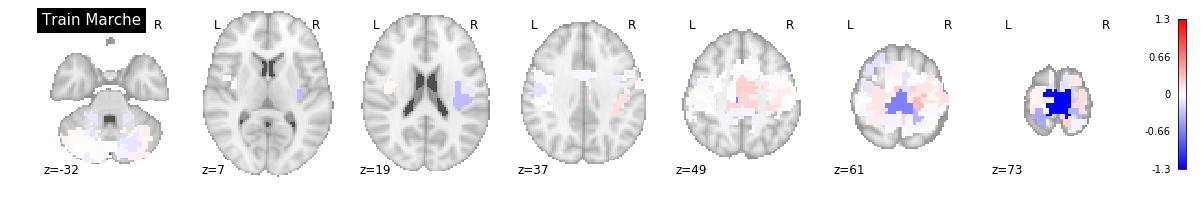

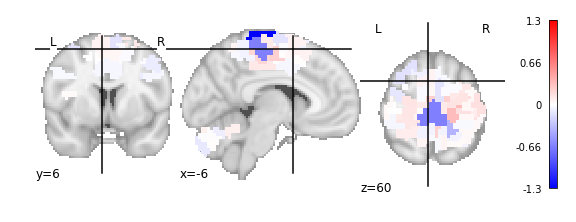

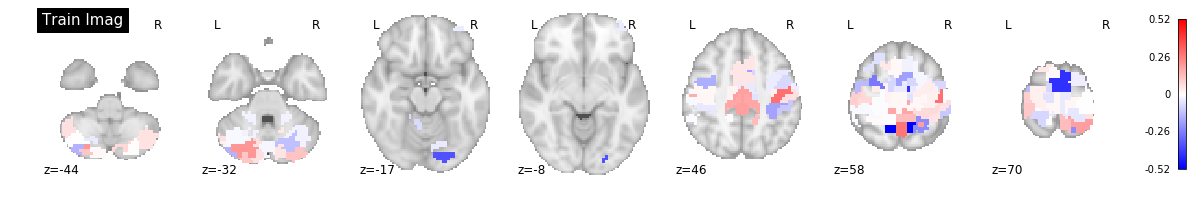

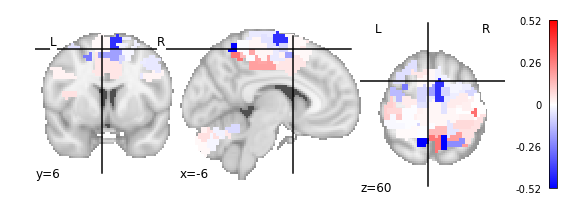

In [97]:

mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='asym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()

weight_img_trimp = masker.inverse_transform(coef_tr_imp)
plot_stat_map(weight_img_trimp, title='Train Marche',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimp,cmap='bwr', cut_coords=[-6, 6, 60])
weight_img_trimag = masker.inverse_transform(coef_tr_imag)
plot_stat_map(weight_img_trimag, title='Train Imag',display_mode='z',cmap='bwr')
plot_stat_map(weight_img_trimag,cmap='bwr', cut_coords=[-6, 6, 60])

In [4]:
plot_selectedregions?

Classification Imagination VS Rest
--
Cross validée par run (9)

In [53]:
condition_mask = np.logical_or(label == b'restimag', label == b'imag')
y = label[condition_mask]
block_cond = block[condition_mask]
cv = LeaveOneLabelOut(block_cond)

for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    roi_cond=roi[condition_mask]



    classifiers_scores = cross_val_score(
                                pipeline, roi_cond, y,cv=cv)
    print n,classifiers_scores.mean()

af 0.773284313725
ba 0.793300653595
br 0.834150326797
my 0.761029411765


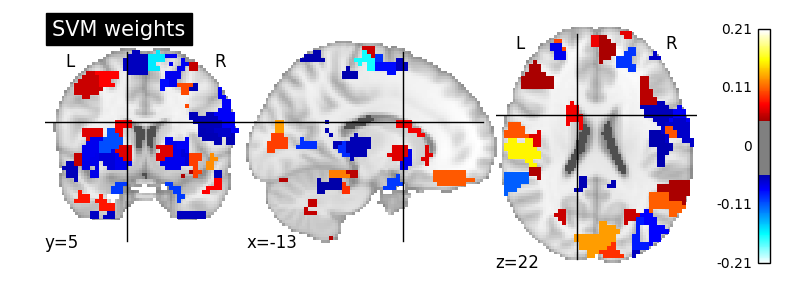

In [58]:
n='my'
roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
roi=np.load(roi_name)['roi']
roi_cond=roi[condition_mask]


mem = Memory('nilearn_cache')
basc = datasets.fetch_atlas_basc_multiscale_2015(version='sym')['scale444']

brainmask = load_mni152_brain_mask()
masker = NiftiLabelsMasker(labels_img = basc, mask_img = brainmask, 
                           memory=mem, memory_level=1, verbose=0,
                           detrend=False, standardize=False,  
                           high_pass=0.01,t_r=2.28,
                           resampling_target='labels')
masker.fit()
pipeline.fit(roi_cond,y)
coef = pipeline.named_steps['svm'].coef_
weight_img = masker.inverse_transform(coef)
plot_stat_map(weight_img, title='SVM weights',threshold=0.05
)

Classification sur differentes modalités : Entrainement (Stimulation vs Rest) et Test (Imagination vs Rest) 
--


Entrainement sur Marche Confortable+Marche Forcée + Pied Droit
--
(si on apprend sur Marche Destructurée on observe des scores à 0.3 ce qui est bizarre...

In [54]:
labelgen=np.loadtxt('D:/irm_marche/label_reststim.txt','S12')

for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    
    roi_train=np.append(roi[0:150],roi[450:750],axis=0) 
    y_train=np.append(labelgen[0:150],labelgen[450:750],axis=0)

    roi_test=roi[300:450]
    y_test=labelgen[300:450]

    pipeline.fit(roi_train,y_train)
    prediction = pipeline.predict(roi_test)
    score=pipeline.score(roi_test,y_test)
    print n,score

af 0.546666666667
ba 0.48
br 0.633333333333
my 0.573333333333


Entrainement seulement sur "Marche Confortable"
--

In [60]:
for n in names:

    roi_name='D:/irm_marche/mni/roi_mni_'+n+'.npz'              
    roi=np.load(roi_name)['roi']
    
    roi_train=roi[0:150]
    y_train=labelgen[0:150]

    roi_test=roi[300:450]
    y_test=labelgen[300:450]

    pipeline.fit(roi_train,y_train)
    prediction = pipeline.predict(roi_test)
    score=pipeline.score(roi_test,y_test)
    print n,score

af 0.586666666667
ba 0.48
br 0.473333333333
my 0.586666666667


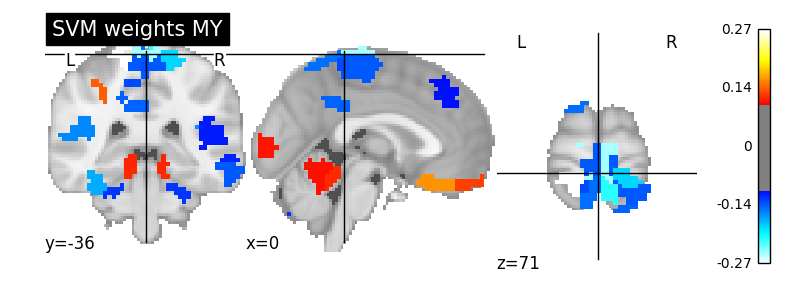

In [61]:
# Meme coeficients que 1er graphique, vu qu'on a appris sur les meme données.
coef = pipeline.named_steps['svm'].coef_
weight_img = masker.inverse_transform(coef)
plot_stat_map(weight_img, title='SVM weights MY',threshold=0.1
)